# Demonstrate possible interpolation workflow using gridspec

We define the interpolation and plotting methods. These tasks will be performed by earthkit-regrid and earthkit-maps in the future.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# Interpolate with scipy. Only works for some regular latlon grids.
# Will be done by eathkit-regrid in the future.
def interpolate(vals, gs, grid=None, area=None):
    # create interpolator object from gridspec
    area1 = gs["area"]
    dx, dy = gs["grid"]
    dy *= -1
    x = np.arange(area1[1], area1[3]+ dx, dx)
    y = np.arange(area1[0], area1[2]+ dy, dy)
    data = vals.reshape(len(y), len(x))
    interp = RegularGridInterpolator((y, x), data)

    # define target points from kwargs
    dx1, dy1 =  grid
    dy1 *= -1
    x1 = np.arange(area[1], area[3] + dx1, dx1)
    y1 = np.arange(area[0], area[2] + dy1, dy1)
    x1g, y1g = np.meshgrid(x1, y1)
    target_points = np.stack([x.ravel() for x in (y1g, x1g)], axis=1)

    # interpolate
    vals1 = interp(target_points)

    # define gridspec for new grid
    gs1 = {
        "type": "regular_ll",
        "grid": grid,
        "area": area,
        "j_points_consecutive": 0,
        "i_scans_negatively": 0,
        "j_scans_positively": 0,
    }

    return vals1, gs1

# Plot field with matplotlib. 
# Will be done by eathkit-maps in the future.
def plot_field(f, title=""):
    lat, lon, vals  = f.data(flatten=False)
    vals = vals - 273.16
    fig, ax = plt.subplots()
    p = ax.pcolormesh(lon, lat, vals, cmap="plasma", shading="nearest")
    fig.colorbar(p)
    plt.title(title)
    plt.show()

The main code.

In [2]:
import earthkit.data
from earthkit.data.core.fieldlist import FieldList

# read 5x5 degree regular_ll grib data on a subarea
earthkit.data.download_example_file("t_75_-60_10_40_5x5.grib1")
ds = earthkit.data.from_source("file", "t_75_-60_10_40_5x5.grib1")

# extract values and gridspec
vals = ds[0].values
gs = ds[0].metadata().gridspec

for k, v in gs.items(): print(f"'{k}': {v}")

'type': regular_ll
'j_points_consecutive': 0
'i_scans_negatively': 0
'j_scans_positively': 0
'grid': [5.0, 5.0]
'area': [75.0, -60.0, 10.0, 40.0]


In [3]:
# perform interpolation onto another grid using values array and gridspec
vals_new, gs_new = interpolate(vals, gs, grid=[2,2], area=[70.0, -50.0, 20.0, 10.0])

for k, v in gs_new.items(): print(f"'{k}': {v}")

'type': regular_ll
'grid': [2, 2]
'area': [70.0, -50.0, 20.0, 10.0]
'j_points_consecutive': 0
'i_scans_negatively': 0
'j_scans_positively': 0


In [4]:
# generate new metadata from the resulting gridspec
md_new = ds[0].metadata().override(gridspec=gs_new)

# generate new fieldlist from the new values array and metadata
ds_new = FieldList.from_numpy(vals_new.flatten(), md_new)

ds_new[0].dump(namespace="geography")

bitmapPresent,0
latitudeOfFirstGridPointInDegrees,70.0
longitudeOfFirstGridPointInDegrees,-50.0
latitudeOfLastGridPointInDegrees,20.0
longitudeOfLastGridPointInDegrees,10.0
iScansNegatively,0
jScansPositively,0
jPointsAreConsecutive,0
jDirectionIncrementInDegrees,2.0
iDirectionIncrementInDegrees,2.0
gridType,regular_ll


Plot the fields.

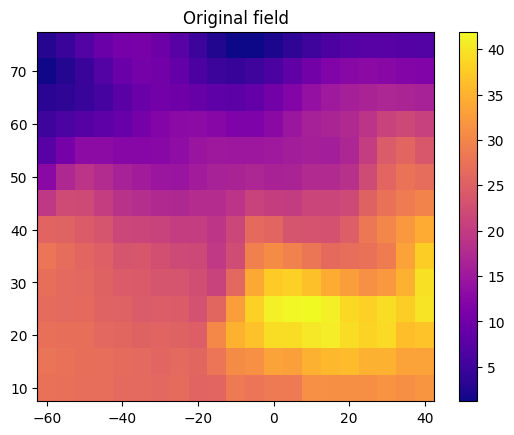

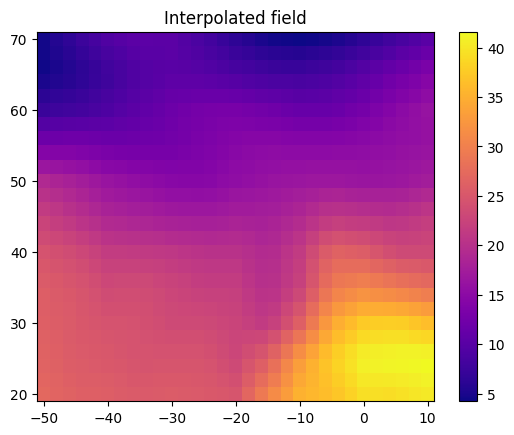

In [5]:
# plot original field
plot_field(ds[0], title="Original field")

# plot interpolated field
plot_field(ds_new[0], title="Interpolated field")

We can save the results into a GRIB file.

In [6]:
path = "_interpolation.grib"
ds_new.save(path)
ds1 = earthkit.data.from_source("file", path)
ds1.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,t,isobaricInhPa,1000,20230831,1200,0,an,0,regular_ll


In [7]:
ds1[0].dump(namespace="geography")

bitmapPresent,0
latitudeOfFirstGridPointInDegrees,70.0
longitudeOfFirstGridPointInDegrees,-50.0
latitudeOfLastGridPointInDegrees,20.0
longitudeOfLastGridPointInDegrees,10.0
iScansNegatively,0
jScansPositively,0
jPointsAreConsecutive,0
jDirectionIncrementInDegrees,2.0
iDirectionIncrementInDegrees,2.0
gridType,regular_ll


In [8]:
ds1[0].metadata().gridspec

GridSpec({'type': 'regular_ll', 'j_points_consecutive': 0, 'i_scans_negatively': 0, 'j_scans_positively': 0, 'grid': [2.0, 2.0], 'area': [70.0, -50.0, 20.0, 10.0]})